<a href="https://colab.research.google.com/github/erichsdb/Neurocomputing/blob/main/notebooks/12-VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational autoencoder

The goal of this exercise is to implement a VAE and apply it on the MNIST dataset. The code is adapted from the keras tutorial:

<https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/generative/ipynb/vae.ipynb>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Fetch the MNIST data
(X_train, t_train), (X_test, t_test) = tf.keras.datasets.mnist.load_data()
print("Training data:", X_train.shape, t_train.shape)
print("Test data:", X_test.shape, t_test.shape)

# Normalize the values
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.

# Mean removal
X_mean = np.mean(X_train, axis=0)
X_train -= X_mean
X_test -= X_mean

# One-hot encoding
T_train = tf.keras.utils.to_categorical(t_train, 10)
T_test = tf.keras.utils.to_categorical(t_test, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data: (60000, 28, 28) (60000,)
Test data: (10000, 28, 28) (10000,)


As a reminder, a VAE is composed of two parts:

* The encoder $q_\varphi(\mathbf{z} | \mathbf{x})$ representing the probability distribution $\mathcal{N}(\mu_\mathbf{x}, \sigma_\mathbf{x})$ of the latent representation $\mathbf{z}$.
* The decoder $p_\theta(\mathbf{x} | \mathbf{z})$ reconstructing the input based on a sampled latent representation $\mathbf{z}$.

Two fundamental aspects of a VAE are not standard in keras:

1. The sampling layer $\mathbf{z} \sim \mathcal{N}(\mu_\mathbf{x}, \sigma_\mathbf{x})$ using the reparameterization trick.
2. The VAE loss:

$$
    \mathcal{L}(\theta, \phi) = \mathbb{E}_{\mathbf{x} \in \mathcal{D}, \xi \sim \mathcal{N}(0, 1)} [ - \log p_\theta(\mathbf{\mu_x} + \mathbf{\sigma_x} \, \xi) + \dfrac{1}{2} \, \sum_{k=1}^K (\mathbf{\sigma_x^2} + \mathbf{\mu_x}^2 -1 - \log \mathbf{\sigma_x^2})]
$$

This will force us to dive a bit deeper into the mechanics of tensorflow, but it is not that difficult since the release of tensorflow 2.0 and the eager execution mode.

## Gradient tapes: redefining the learning procedure

Let's first have a look at how to define custom losses. There is an easier way to define custom losses with keras (<https://keras.io/api/losses/#creating-custom-losses>), but we will need this sightly more complicated variant for the VAE.

Let's reuse the CNN you implemented last time using the functional API on MNIST, but not compile it yet:

In [15]:
def create_model():
    # Delete all previous models to free memory
    tf.keras.backend.clear_session()

    inputs = tf.keras.layers.Input((28, 28, 1))

    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='valid')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(150, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    print(model.summary())

    return model


In order to have access to the internals of the training procedure, one of the possible methods is to inherit the `tf.keras.Model` class and redefine the `train_step` and (optionally) `test_step` methods.

The following cell redefines a model for the previous CNN and minimizes the categorical cross-entropy while tracking the loss and accuracy, so it is completely equivalent to:

```python
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=['accuracy'])
```

Have a look at the code, but we will go through it step by step afterwards.

In [5]:
class CNN(tf.keras.Model):

    def __init__(self):
        super(CNN, self).__init__()

        # Model
        self.model = create_model()

        # Metrics
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.accuracy_tracker = tf.keras.metrics.Accuracy(name="accuracy")

    @property
    def metrics(self):
        "Track the loss and accuracy"
        return [self.loss_tracker, self.accuracy_tracker]

    def train_step(self, data):

        # Get the data of the minibatch
        X, t = data

        # Use GradientTape to record everything we need to compute the gradient
        with tf.GradientTape() as tape:

            # Prediction using the model
            y = self.model(X, training=True)

            # Cross-entropy loss
            loss = tf.reduce_mean(
                tf.reduce_sum(
                    - t * tf.math.log(y), # Cross-entropy
                    axis=1 # First index is the batch size, the second is the classes
                )
            )

        # Compute gradients
        grads = tape.gradient(loss, self.trainable_weights)

        # Apply gradients using the optimizer
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update metrics
        self.loss_tracker.update_state(loss)
        true_class = tf.reshape(tf.argmax(t, axis=1), shape=(-1, 1))
        predicted_class = tf.reshape(tf.argmax(y, axis=1), shape=(-1, 1))
        self.accuracy_tracker.update_state(true_class, predicted_class)

        # Return a dict mapping metric names to current value
        return {"loss": self.loss_tracker.result(), 'accuracy': self.accuracy_tracker.result()}

    def test_step(self, data):

        # Get data
        X, t = data

        # Prediction
        y = self.model(X, training=False)

        # Loss
        loss = tf.reduce_mean(
            tf.reduce_sum(
                    - t * tf.math.log(y), # Cross-entropy
                    axis=1
            )
        )

        # Update metrics
        self.loss_tracker.update_state(loss)
        true_class = tf.reshape(tf.argmax(t, axis=1), shape=(-1, 1))
        predicted_class = tf.reshape(tf.argmax(y, axis=1), shape=(-1, 1))
        self.accuracy_tracker.update_state(true_class, predicted_class)

        # Return a dict mapping metric names to current value
        return {"loss": self.loss_tracker.result(), 'accuracy': self.accuracy_tracker.result()}


The constructor of the new `CNN` class creates the model defined by `create_model()` and stores it as an attribute.

*Note:* it would be actually more logical to create layers directly here, as we now have a model containing a model, but this is simpler for the VAE architecture.

The constructor also defines the metrics that should be tracked when training. Here we track the loss and accuracy of the model, using objects of `tf.keras.metrics` (check <https://keras.io/api/metrics/> for a list of metrics you can track).

The metrics are furthermore declared in the `metrics` property, so that you can now avoid passing `metrics=['accuracy']` to `compile()`. The default `Model` only has `'loss'` as a default metric.

```python
class CNN(tf.keras.Model):

    def __init__(self):
        super(CNN, self).__init__()

        # Model
        self.model = create_model()

        # Metrics
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.accuracy_tracker = tf.keras.metrics.Accuracy(name="accuracy")

    @property
    def metrics(self):
        "Track the loss and accuracy"
        return [self.loss_tracker, self.accuracy_tracker]
```

The training procedure is defined in the `train_step(data)` method of the class.

```python
    def train_step(self, data):
        
        # Get the data of the minibatch
        X, t = data
```

`data` is a minibatch of data iteratively passed by `model.fit()`. `X` and `t` are **tensors** (multi-dimensional arrays) representing the inputs and targets. On MNIST, `X` has the shape `(batch_size, 28, 28, 1)` and `t` is `(batch_size, 10)`. The rest of the method defines the loss function, computes its gradient w.r.t the learnable parameters and pass it the optimizer to change their value.

To get the output of the network on the minibatch, one simply has to call:

```python
y = self.model(X)
```

which returns a `(batch_size, 10)` tensor. However, this forward pass does not keep in memory the activity of the hidden layers: all it cares about is the prediction. But when applying backpropagation, you need this internal information to compute the gradient.

In tensorflow 2.x, you can force the model to record internal activity using the eager execution mode and **gradient tapes** (as in the tape of an audio recorder):

```python
with tf.GradientTape() as tape:
    y = self.model(X, training=True)
```

It is not a big problem if you are not familiar with Python contexts: all you need to know is that the `tape` object will "see" everything that happens when calling `y = self.model(X, training=True)`, i.e. it will record the hidden activations in the model.

The next thing to do inside the tape is to compute the loss of the model on the minibatch. Here we minimize the categorical cross-entropy:

$$\mathcal{L}(\theta) = \frac{1}{N} \, \sum_{i=1}^N \sum_{j=1}^C - t^i_j \, \log y^i_j$$

where $N$ is the batch size, $C$ the number of classes, $t^i_j$ the $j$-th element of the $i$-th target vector and $y^i_j$ the predicted probability for class $j$ and the $i$-th sample.

We therefore need to take our two tensors `t` and `y` and compute that loss function, but recording everything (so inside the tape context).

There are several ways to do that, for example by calling directly the built-in categorical cross-entropy object of keras on the data:

```python
loss = tf.keras.losses.CategoricalCrossentropy()(t, y)
```

Another way to do it is to realize that tensorflow tensors are completely equivalent to numpy arrays: you can apply mathematical operations (sum, element-wise multiplication, log, etc.) on them as if they were regular arrays (internally, that is another story...).

You can for example add `t` and two times ` y` as they have the same shape:

```python
loss = t + 2.0 * y
```

loss would then be a tensor of the same shape. You can get the shape of a tensor with `tf.shape(loss)` just like in numpy.

Mathematical operation are in the tf.math module (<https://www.tensorflow.org/api_docs/python/tf/math>), for example with the log:

```python
loss = t + tf.math.log(y)
```

`*` is by default the element-wise multiplication:

```python
loss = - t * tf.math.log(y)
```

Here, `loss` is still a `(batch_size, 10)` tensor. We still need to sum over the 10 classes and take the mean over the minibatch to get a single number.

Summing over the second dimension of this tensor can be done with `tf.reduce_sum`:

```python
loss = tf.reduce_sum(
    - t * tf.math.log(y),
    axis=1 # First index is the batch size, the second is the classes
)
```

This gives us a vector with `batch_size` elements containing the individual losses for the minibatch. In order to compute its mean over the minibatch, we only need to call `tf.reduce_mean()`:

```python
loss = tf.reduce_mean(
            tf.reduce_sum(
                - t * tf.math.log(y),
                axis=1
            )
        )
```

That's it, we have redefined the categorical cross-entropy loss function on a minibatch using elementary numerical operations! Doing this inside the tape allows tensorflow to keep track of each sample of the minibatch individually: otherwise, it would not know how the loss (a single number) depends on each prediction $y^i$ and therefore on the parameters of the NN.

Now that we have the loss function as a function of the trainable parameters of the NN on the minibatch, we can ask tensorflow for its gradient:


```python
grads = tape.gradient(loss, self.trainable_weights)
```

Backpropagation is still a one-liner. `self.trainable_weights` contains all weights and biases in the model, while `tape.gradient()` apply backpropagation to compute the gradient of the loss function w.r.t them.

We can then pass this gradient to the optimizer (SGD or Adam, which will be passed to `compile()`) so that it updates the parameters:

```python
self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
```

Finally, we can update our metrics so that our custom loss and the accuracy are tracked during training:

```python
self.loss_tracker.update_state(loss)

true_class = tf.reshape(tf.argmax(t, axis=1), shape=(-1, 1))
predicted_class = tf.reshape(tf.argmax(y, axis=1), shape=(-1, 1))
self.accuracy_tracker.update_state(true_class, predicted_class)
```

For the accuracy, we need to pass the class (predicted or ground truth), not the probabilities.

The `test_step()` method does roughly the same as `train_step()`, except that it does not modify the parameters: it is called on the validation data in order to compute the metrics. As we do not learn, we do not actually need the tape.

**Q:** Create the custom CNN model and train it on MNIST. When compiling the model, you only need to pass it the right optimizer, as the loss function and the metrics are already defined in the model. Check that you get the same results as last time.

In [16]:
model = create_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=['accuracy'])

# History tracks the evolution of the metrics during learning
history = tf.keras.callbacks.History()

# Training procedure
model.fit(
    X_train, T_train, # training data
    batch_size=64,  # batch size
    epochs=20, # Maximum number of epochs
    validation_split=0.1, # Perceptage of training data used for validation
    callbacks=[history] # Track the metrics at the end of each epoch
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 150)                 │         240,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,510 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 260,476 (1017.48 KB)

 Trainable params: 260,476 (1017.48 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7563 - loss: 0.7344 - val_accuracy: 0.9790 - val_loss: 0.0751
Epoch 2/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9496 - loss: 0.1633 - val_accuracy: 0.9835 - val_loss: 0.0564
Epoch 3/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9618 - loss: 0.1265 - val_accuracy: 0.9870 - val_loss: 0.0460
Epoch 4/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9677 - loss: 0.1154 - val_accuracy: 0.9898 - val_loss: 0.0383
Epoch 5/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9717 - loss: 0.0966 - val_accuracy: 0.9888 - val_loss: 0.0386
Epoch 6/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9721 - loss: 0.0903 - val_accuracy: 0.9900 - val_loss: 0.0344
Epoch 7/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9746 - loss: 0.0829 - val_accuracy: 0.9895 - val_loss: 0.0349
Epoch 8/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9764 - loss: 0.0744 - val_accura

**Q:** Redefine the model so that it minimizes the mean-square error $(t-y)^2$ instead of the cross-entropy. What happens?

*Hint:* squaring a tensor element-wise is done by applying `**2` on it just like in numpy.

In [17]:
model = create_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    loss="mean_squared_error",
    optimizer=optimizer,
    metrics=['accuracy'])

# History tracks the evolution of the metrics during learning
history = tf.keras.callbacks.History()

# Training procedure
model.fit(
    X_train, T_train, # training data
    batch_size=64,  # batch size
    epochs=20, # Maximum number of epochs
    validation_split=0.1, # Perceptage of training data used for validation
    callbacks=[history] # Track the metrics at the end of each epoch
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 150)                 │         240,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,510 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 260,476 (1017.48 KB)

 Trainable params: 260,476 (1017.48 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7428 - loss: 0.0331 - val_accuracy: 0.9780 - val_loss: 0.0032
Epoch 2/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9496 - loss: 0.0077 - val_accuracy: 0.9850 - val_loss: 0.0023
Epoch 3/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9619 - loss: 0.0059 - val_accuracy: 0.9867 - val_loss: 0.0020
Epoch 4/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9649 - loss: 0.0055 - val_accuracy: 0.9885 - val_loss: 0.0018
Epoch 5/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9707 - loss: 0.0046 - val_accuracy: 0.9877 - val_loss: 0.0018
Epoch 6/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9714 - loss: 0.0044 - val_accuracy: 0.9878 - val_loss: 0.0019
Epoch 7/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9729 - loss: 0.0042 - val_accuracy: 0.9897 - val_loss: 0.0016
Epoch 8/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9756 - loss: 0.0038 - val_accura

## Custom layers

Keras layers take a tensor as input (the output of the previous layer on a minibatch) and transform it into another tensor, possibly using trainable parameters. As we have seen, tensorflow allows to manipulate tensors and apply differentiable operations on them, so we could redefine the function made by a keras layer using tensorflow operations.

The following cell shows how to implement a dummy layer that takes a tensor $T$ as input (the first dimension is the batch size) and returns the tensor $\exp - \lambda \, T$, $\lambda$ being a fixed parameter.

In [19]:
class ExponentialLayer(tf.keras.layers.Layer):
    """Layer performing element-wise exponentiation."""

    def __init__(self, factor=1.0):
        super(ExponentialLayer, self).__init__()
        self.factor = factor

    def call(self, inputs):
        return tf.exp(- self.factor*inputs)

`ExponentialLayer` inherits from `tf.keras.layers.Layer` and redefines the `call()` method that defines the forward pass. Here we simply return the corresponding tensor.

The layer can then be used in a functional model directly:

```python
x = ExponentialLayer(factor=1.0)(x)
```

As we use tensorflow operators, it knows how to differentiate it when applying backpropagation.

More information on how to create new layers can be found at <https://keras.io/guides/making_new_layers_and_models_via_subclassing>. FYI, this is how you would redefine a fully-connected layer without an activation function, using a trainable weight matrix and bias vector:

```python
class Linear(tf.keras.layers.Layer):
    def __init__(self, units=32):
        "Number of neurons in the layer."
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        "Create the weight matrix and bias vector once we know the shape of the previous layer."
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        "Return W*X + b"
        return tf.matmul(inputs, self.w) + self.b
```

**Q:** Add the exponential layer to the CNN between the last FC layer and the output layer. Change the value of the parameter. Does it still work?

In [22]:
# Delete all previous models to free memory
tf.keras.backend.clear_session()

inputs = tf.keras.layers.Input((28, 28, 1))

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='valid')(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(150, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)


x = ExponentialLayer(factor=0.1)(x)

outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
print(model.summary())

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=['accuracy'])

# History tracks the evolution of the metrics during learning
history = tf.keras.callbacks.History()

# Training procedure
model.fit(
    X_train, T_train, # training data
    batch_size=64,  # batch size
    epochs=20, # Maximum number of epochs
    validation_split=0.1, # Perceptage of training data used for validation
    callbacks=[history] # Track the metrics at the end of each epoch
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 150)                 │         240,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ exponential_layer (ExponentialLayer) │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,510 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 260,476 (1017.48 KB)

 Trainable params: 260,476 (1017.48 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6188 - loss: 1.3527 - val_accuracy: 0.9643 - val_loss: 0.1215
Epoch 2/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9331 - loss: 0.2925 - val_accuracy: 0.9745 - val_loss: 0.0807
Epoch 3/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9499 - loss: 0.1928 - val_accuracy: 0.9810 - val_loss: 0.0648
Epoch 4/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9561 - loss: 0.1587 - val_accuracy: 0.9812 - val_loss: 0.0594
Epoch 5/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9614 - loss: 0.1363 - val_accuracy: 0.9835 - val_loss: 0.0565
Epoch 6/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9620 - loss: 0.1281 - val_accuracy: 0.9838 - val_loss: 0.0576
Epoch 7/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9688 - loss: 0.1089 - val_accuracy: 0.9858 - val_loss: 0.0484
Epoch 8/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9693 - loss: 0.1069 - val_accura

## Variational autoencoder

We are now ready to implement the VAE. We are going to redefine the training set, as we want pixel values to be between 0 and 1 (so that we can compute a cross-entropy). Therefore, we do not perform removal:



In [23]:
# Fetch the MNIST data
(X_train, t_train), (X_test, t_test) = tf.keras.datasets.mnist.load_data()
print("Training data:", X_train.shape, t_train.shape)
print("Test data:", X_test.shape, t_test.shape)

# Normalize the values
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.

# One-hot encoding
T_train = tf.keras.utils.to_categorical(t_train, 10)
T_test = tf.keras.utils.to_categorical(t_test, 10)

Training data: (60000, 28, 28) (60000,)
Test data: (10000, 28, 28) (10000,)


### Encoder

The encoder can have any form, the only constraint is that is takes an input $(28, 28, 1)$ and outputs two vectors $\mu$ and $\log(\sigma)$ of size `latent_dim`, the parameters of the normal distribution representing the input. We are going to use only `latent_dim=2` latent dimensions, but let's make the code generic.

For a network to have two outputs, one just needs to use the functional API to create the graph:

```python
# Previous layer
x = tf.keras.layers.Dense(N, activation="relu")(x)

# First output takes input from x
z_mean = tf.keras.layers.Dense(latent_dim)(x)

# Second output also takes input from x  
z_log_var = tf.keras.layers.Dense(latent_dim)(x)
```

This would not be possible using the Sequential API, but is straightforward using the functional one, as you decide from where a layer takes its inputs.

What we still need and is not standard in keras is a sampling layer that implements the **reparameterization trick**:

$$\mathbf{z} = \mu + \sigma \, \xi$$

where $\xi$ comes from the standard normal distribution $\mathcal{N}(0, 1)$.

For technical reasons, it is actually better when `z_log_var` represents $\log \sigma^2$ instead of $\sigma$, as it can take both positive and negative values, while $\sigma$ could only be strictly positive.

$$\text{z\_log\_var} = \log \, \sigma^2$$

$$\sigma = \exp \dfrac{\text{z\_log\_var}}{2}$$

We therefore want a layer that computes:

```python
z = z_mean + tf.math.exp(0.5 * z_log_var) * xi
```

on the tensors of shape `(batch_size, latent_dim)`. To sample the standard normal distribution, you can use tensorflow:

```python
xi = tf.random.normal(shape=(batch_size, latent_dim) mean=0.0, stddev=1.0)
```

**Q:** Create a custom `SamplingLayer` layer that takes inputs from `z_mean` and `z_log_var`, being called like this:

```python
z = SamplingLayer()([z_mean, z_log_var])
```

In order to get each input separately, the `inputs` argument can be split:

```python
def call(self, inputs):
    z_mean, z_log_var = inputs
```

The only difficulty is to pass the correct dimensions to `xi`, as you do not know the batch size yet. You can retrieve it using the shape of `z_mean`:

```python
batch_size = tf.shape(z_mean)[0]
latent_dim = tf.shape(z_mean)[1]
```

In [33]:
class SamplingLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(SamplingLayer, self).__init__()

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch_size = tf.shape(z_mean)[0]
        latent_dim = tf.shape(z_mean)[1]

        xi = tf.random.normal(shape=(batch_size, latent_dim), mean=0.0, stddev=1.0)
        return z_mean + tf.math.exp(0.5 * z_log_var) * xi

We can now create the encoder in a `create_encoder(latent_dim)` method that return an uncompiled model.

You can put what you want in the encoder as long as it takes a `(28, 28, 1)` input and returns the three layers `[z_mean, z_log_var, z]` (we need `z_mean` and `z_log_var` to define the loss, normally you only need `z`):

```python
def create_encoder(latent_dim):

    inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    
    # Stuff, with x being the last FC layer

    z_mean = tf.keras.layers.Dense(latent_dim)(x)
    
    z_log_var = tf.keras.layers.Dense(latent_dim)(x)
    
    z = SamplingLayer()([z_mean, z_log_var])

    model = tf.keras.Model(inputs, [z_mean, z_log_var, z])
    
    print(model.summary())

    return model
```

One suggestion would be to use two convolutional layers with a stride of 2 (replacing max-pooling) and one fully-connected layer with enough neurons, but you do what you want.

**Q:** Create the encoder.

In [39]:
def create_encoder(latent_dim):

    inputs = tf.keras.layers.Input(shape=(28, 28, 1))

    x = tf.keras.layers.Conv2D(32, (3, 3), strides=2, activation='relu', padding='valid')(inputs)

    x = tf.keras.layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding='valid')(x)

    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(16, activation="relu")(x)

    z_mean = tf.keras.layers.Dense(latent_dim)(x)

    z_log_var = tf.keras.layers.Dense(latent_dim)(x)

    z = SamplingLayer()([z_mean, z_log_var])

    model = tf.keras.Model(inputs, [z_mean, z_log_var, z])

    print(model.summary())

    return model

The decoder is a bit more tricky. It takes the vector `z` as an input (`latent_dim=2` dimensions) and should output an image (28, 28, 1) with pixels normailzed between 0 and 1. The output layer should therefore use the `'sigmoid'` transfer function:

```python
def create_decoder(latent_dim):
    
    inputs = tf.keras.layers.Input(shape=(latent_dim,))

    # Stuff, with x being a transposed convolution layer of shape (28, 28, N)
    
    outputs = tf.keras.layers.Conv2DTranspose(1, (3, 3), activation="sigmoid", padding="same")(x)
    
    model = tf.keras.Model(inputs, outputs)
    print(model.summary())
    
    return model
```

The decoder has to use **transposed convolutions** to upsample the tensors instead of downsampling them. Check the doc of Conv2DTranspose at <https://keras.io/api/layers/convolution_layers/convolution2d_transpose/>.

In order to build the decoder, you have to be careful when it comes to tensor shapes: the output must be **exactly** (28, 28, 1), not (26, 26, 1), otherwise you will not be able to compute the reconstruction loss. You need to be careful with the stride (upsampling ratio) and padding method ('same' or 'valid') of the layers you add. Do not hesitate to create dummy models and print their summary to see the shapes.

Another trick is that you need to transform the vector `z` with `latent_dim=2` elements into a 3D tensor before applying transposed convolutions (i.e. the inverse of `Flatten()`). If you for example want a tensor of shape (7, 7, 64) as the input to the first transposed convolution, you could project the vector to a fully connected layer with `7*7*64` neurons:

```python
x = tf.keras.layers.Dense(7 * 7 * 64, activation="relu")(inputs)
```

and reshape it to a (7, 7, 64) tensor:

```python
x = tf.keras.layers.Reshape((7, 7, 64))(x)
```

**Q:** Create the decoder.

In [41]:
def create_decoder(latent_dim):

    inputs = tf.keras.layers.Input(shape=(latent_dim,))

    # Stuff, with x being a transposed convolution layer of shape (28, 28, N)
    x = tf.keras.layers.Dense(7 * 7 * 64, activation="relu")(inputs)
    x = tf.keras.layers.Reshape((7, 7, 64))(x)

    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), activation="relu", strides=2, padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(32, (3, 3), activation="relu", strides=2, padding="same")(x)

    outputs = tf.keras.layers.Conv2DTranspose(1, (3, 3), activation="sigmoid", padding="same")(x)

    model = tf.keras.Model(inputs, outputs)
    print(model.summary())

    return model

**Q:** Create a custom `VAE` model (inheriting from `tf.keras.Model`) that:

* takes the latent dimension as argument:

```python
vae = VAE(latent_dim=2)
```

* creates the encoder and decoder in the constructor.

* tracks the reconstruction and KL losses as metrics.

* does not use validation data (i.e., do not implement `test_step()` and do not provide any validation data to `fit()`).

* computes the reconstruction loss using binary cross-entropy over all pixels of the reconstructed image:

$$\mathcal{L}_\text{reconstruction}(\theta) = \frac{1}{N} \sum_{i=1}^N \sum_{w, h \in \text{pixels}} - t^i(w, h) \, \log y^i(w, h) - (1 - t^i(w, h)) \, \log(1 - y^i(w, h))$$

where $t^i(w, h)$ is the pixel of coordinates $(w, h)$ (between 0 and 27) of the $i$-th image of the minibatch.

* computes the KL divergence loss for the encoder:

$$\mathcal{L}_\text{KL}(\theta) = \frac{1}{2 N} \sum_{i=1}^N (\exp(\text{z\_log\_var}^i) + (\text{z\_mean}^i)^2 - 1 - \text{z\_log\_var}^i)$$

* minimizes the total loss:

$$\mathcal{L}(\theta) = \mathcal{L}_\text{reconstruction}(\theta) + \mathcal{L}_\text{KL}(\theta)$$

Train it on the MNIST images for 30 epochs (or more) with the right batch size and a good optimizer (`history = vae.fit(X_train, X_train, epochs=30, batch_size=b)`). How do the losses evolve?

*Hint:* for the reconstruction loss, you can implement the formula using tensorflow operations, or call `tf.keras.losses.binary_crossentropy(t, y)` directly.

Do not worry if your reconstruction loss does not go to zero, but stays in the hundreds, it is normal. Use the next cell to visualize the reconstructions.

*Note:* The KL is expressed for a single sample as:

$$\mathcal{L}_\text{KL}(\theta) =  \dfrac{1}{2} \, (\mathbf{\sigma_x^2} + \mathbf{\mu_x}^2 - 1 - \log \mathbf{\sigma_x^2})$$

With  $\text{z\_log\_var} = \log \, \sigma^2$ or $\sigma = \exp \dfrac{\text{z\_log\_var}}{2}$, this becomes:

$$\mathcal{L}_\text{KL}(\theta) =  \dfrac{1}{2} \, (\exp \text{z\_log\_var} + \mathbf{\mu_x}^2 - 1 - \text{z\_log\_var})$$

In [42]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = create_encoder(latent_dim)

        # Decoder
        self.decoder = create_decoder(latent_dim)

        # Track losses
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def train_step(self, data):

        with tf.GradientTape() as tape:

            # Data: input = output
            X, t = data

            # Encoder
            z_mean, z_log_var, z = self.encoder(X)

            # Decoder
            y = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                   #- t * tf.math.log(y) - (1. - t) * tf.math.log(1. - y),
                   tf.keras.losses.binary_crossentropy(t, y),
                    axis=(1, 2)
                )
            )

            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    0.5 * (tf.exp(z_log_var) + tf.square(z_mean) - 1 - z_log_var ),
                    axis=1
                )
            )

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]


In [43]:
# Delete all previous models to free memory
tf.keras.backend.clear_session()

# Create the VAE with 2 latent variables
vae = VAE(latent_dim=2)

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile
vae.compile(optimizer=optimizer)

# Train the VAE
history = vae.fit(X_train, X_train, epochs=30, batch_size=128)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 13, 13, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 6, 6, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 2304)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │         36,880 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_layer            │ (None, 2)              │              0 │ dense_1[0][0],         │
│ (SamplingLayer)           │                        │                │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 55,764 (217.83 KB)

 Trainable params: 55,764 (217.83 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - kl_loss: 4.7051 - loss: 385.6468 - reconstruction_loss: 380.9418
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - kl_loss: 4.0704 - loss: 204.7436 - reconstruction_loss: 200.6732
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - kl_loss: 3.2515 - loss: 192.5797 - reconstruction_loss: 189.3281
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - kl_loss: 4.9593 - loss: 179.2354 - reconstruction_loss: 174.2760
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 5.1510 - loss: 174.8233 - reconstruction_loss: 169.6723
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 5.1844 - loss: 171.7597 - reconstruction_loss: 166.5753
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - kl_loss: 5.2492 - loss: 168.4257 - reconstruction_loss: 163.1766
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 5.3249 - loss: 166.6387 - reconstruction_loss: 161.3138
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5

**Q:** The following cell allows to regularly sample the latent space and reconstruct the images. It makes the assumption that the decoder is stored at `vae.decoder`, adapt it otherwise. Comment on the generated samples. Observe in particular the smooth transitions between similar digits.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

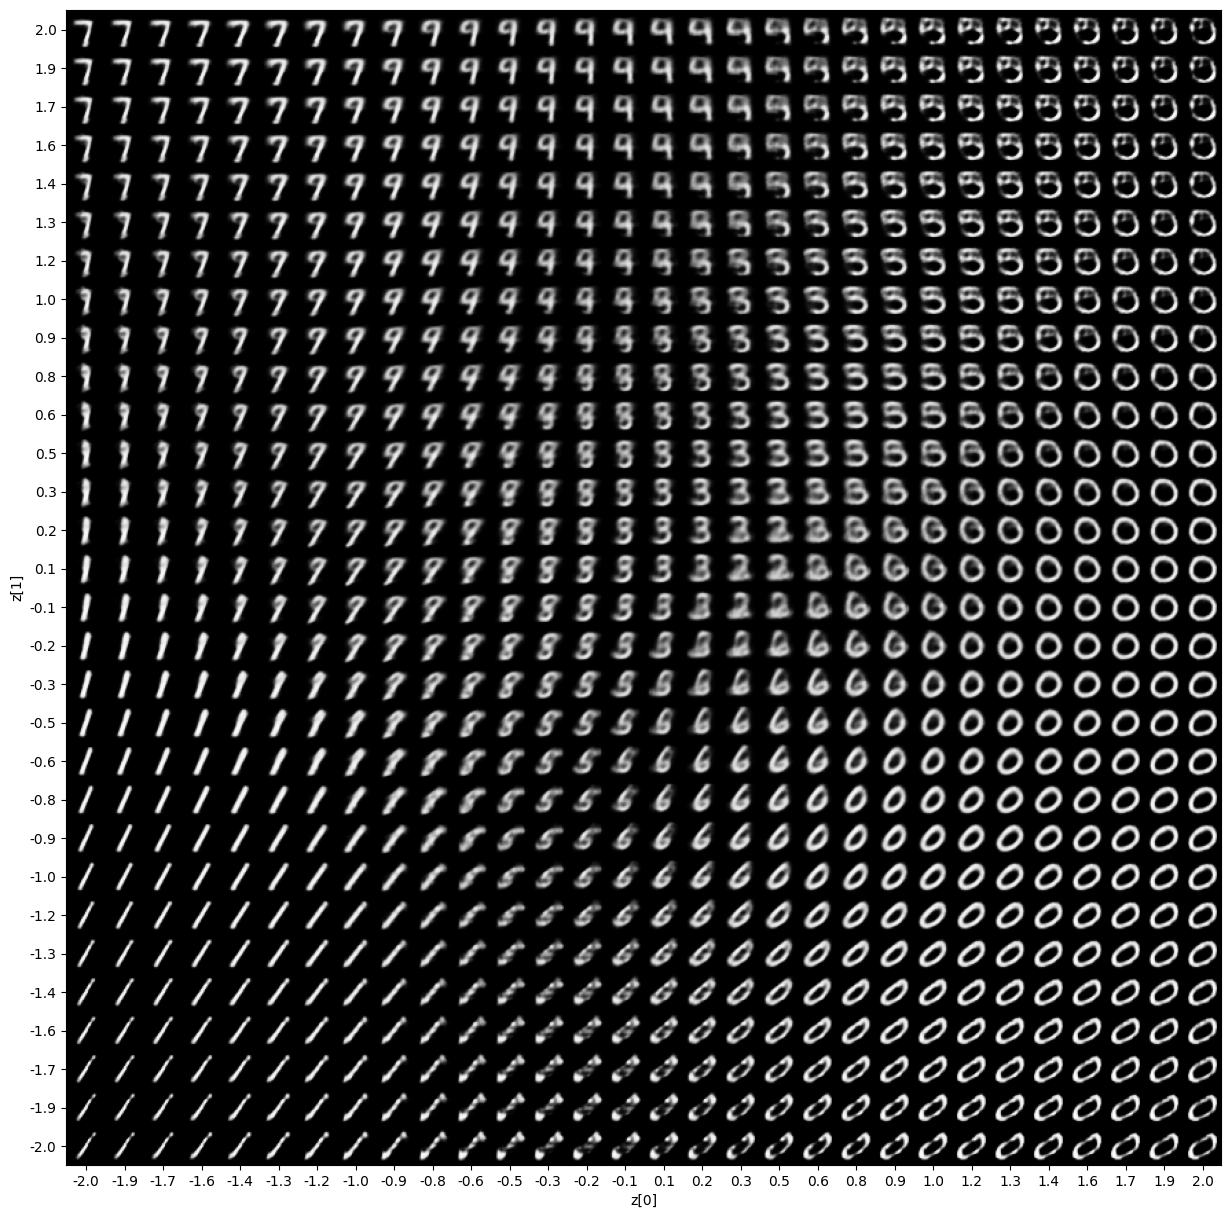

In [44]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 2.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

**Q:** The following cell visualizes the latent representation for the training data, using different colors for the digits. What do you think?

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


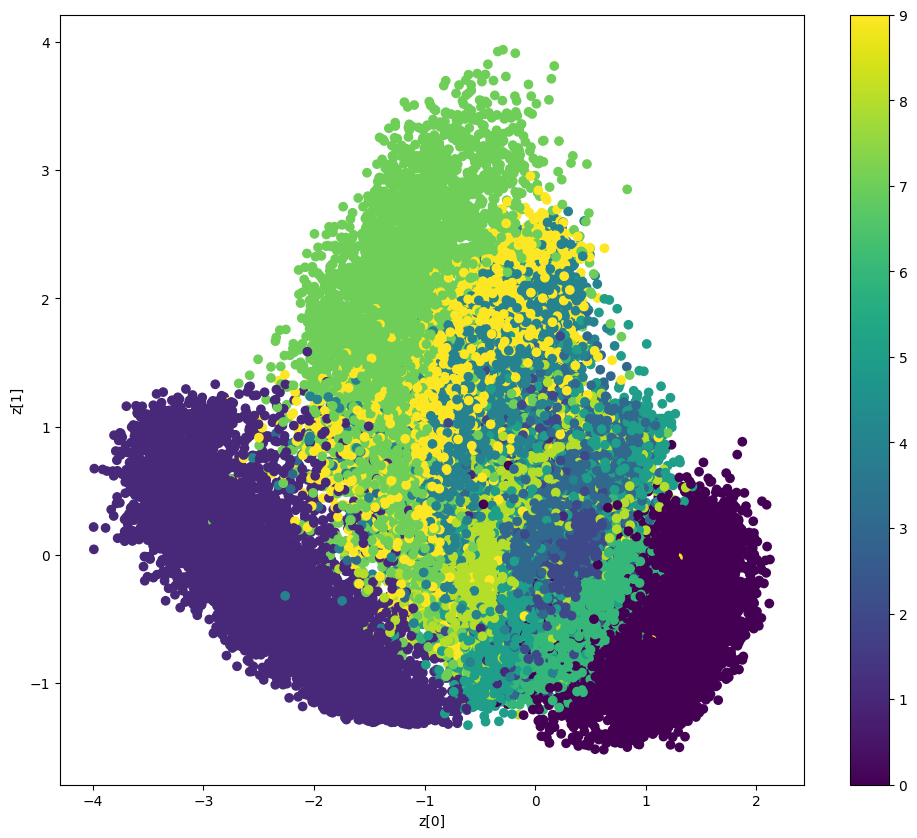

In [45]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


plot_label_clusters(vae, X_train, t_train)